In [1]:

import os.path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from astropy.units import spectral
from scipy.signal import spectrogram

from utils.other import (
    split_array,
    OutlierData,
    interpolate_missing,
    align_high2low,
    get_middle_element,
    get_3arrs,
    split_array_optimized,
)
import utils.spectral
from utils import histogram2d, coordinate
from pyaw import utils
from core import swarm
from configs import ProjectConfigs
from pyaw.utils.plot import plot_multi_panel, plot_gridded_panels
from pyaw.utils import spectral

#  --- file_paths

data_dir_path = ProjectConfigs.data_dir_path
file_path_b = os.path.join(
    data_dir_path, "SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl"
)
file_path_b_aux = os.path.join(
    data_dir_path, "aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl"
)
file_path_b_igrf = os.path.join(
    data_dir_path, "IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl"
)
file_path_tct16 = os.path.join(
    data_dir_path, "SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl"
)
file_path_tct16_aux = os.path.join(
    data_dir_path, "aux_SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl"
)

#  --- read data as df

df_b = pd.read_pickle(file_path_b)
df_b_aux = pd.read_pickle(file_path_b_aux)
df_b_IGRF = pd.read_pickle(file_path_b_igrf)
df_e = pd.read_pickle(file_path_tct16)
df_e_aux = pd.read_pickle(file_path_tct16_aux)

#  --- process data: clip needed data for efficiency

df_b_clip = df_b[["B_NEC", "Longitude", "Latitude", "Radius", "q_NEC_CRF"]]
df_b_aux_clip = df_b_aux[["QDLat", "QDLon", "MLT"]]
df_b_IGRF_clip = df_b_IGRF[["B_NEC_IGRF"]]
df_e_clip = df_e[["Longitude", "Latitude", "Radius", "VsatE", "VsatN", "Ehy", "Ehx"]]
df_e_aux_clip = df_e_aux[["QDLat", "QDLon", "MLT"]]

#  --- process data: use time to clip data again

st = "20160311T064700"
et = "20160311T064900"
df_b_clip = df_b_clip.loc[pd.Timestamp(st) : pd.Timestamp(et)]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st) : pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st) : pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st) : pd.Timestamp(et)]
df_e_aux_clip = df_e_aux_clip.loc[pd.Timestamp(st) : pd.Timestamp(et)]

#  --- process data: electric field
Ehx = df_e_clip["Ehx"].values
Ehx_outlier = OutlierData.set_outliers_nan_std(Ehx, 1, print_=True)
Ehx_outlier_interp = interpolate_missing(Ehx_outlier, df_e_clip.index.values)

Ehy = df_e_clip["Ehy"].values
Ehy_outlier = OutlierData.set_outliers_nan_std(Ehy, 1, print_=True)
Ehy_outlier_interp = interpolate_missing(Ehy_outlier, df_e_clip.index.values)

VsatN = df_e_clip["VsatN"].values
VsatE = df_e_clip["VsatE"].values

#  --- process data: electric field: sc2nec
rotmat_nec2sc, rotmat_sc2nec = coordinate.NEC2SCandSC2NEC.get_rotmat_nec2sc_sc2nec(
    VsatN, VsatE
)
E_north, E_east = coordinate.NEC2SCandSC2NEC.do_rotation(
    -Ehx_outlier_interp, -Ehy_outlier_interp, rotmat_sc2nec
)  # todo: why need '-'

#  ---process data: magnetic field
B_N, B_E, _ = get_3arrs(df_b_clip["B_NEC"].values)
B_N_IGRF, B_E_IGRF, _ = get_3arrs(df_b_IGRF_clip["B_NEC_IGRF"].values)
delta_B_E = B_E - B_E_IGRF
delta_B_N = B_N - B_N_IGRF

#  ---process data: magnetic field: downsample, use align time method
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values
delta_B_E_align = align_high2low(delta_B_E, datetimes_b, datetimes_e)
delta_B_N_align = align_high2low(delta_B_N, datetimes_b, datetimes_e)

#  ---process data: unify datetimes
datetimes = datetimes_e

#  ---spectrogram: settings
fs = 16
window = "hann"
spectrogram_window_seconds = 4
nperseg = int(spectrogram_window_seconds * fs)
noverlap = nperseg // 2  # 重叠率一般为50%

#  ---spectrogram: choose a disturb magnetic field and electric field pair.
# delta_B: East, E: North
frequencies, ts, Sxx_b = spectrogram(
    delta_B_E_align,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e = spectrogram(
    E_north, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode="complex"
)

# ---spectrogram: get datetime type ndarray for the plot
ts_dt64 = datetimes[0] + [np.timedelta64(int(_), "s") for _ in ts]

# ---spectrogram: get the cross spectral
cpsd = Sxx_e * np.conj(Sxx_b)

#  get lat and MLT

latitudes = df_e_clip["Latitude"].values
mlts = df_e_aux_clip["MLT"].values

#  --- use new method to get Coherency ---
segment_length_sec = 4  # 越大最后得到的数组的长度越小，取和之前的spectrogram输入的窗口长度是一个不错的选择
try:
    mid_times_all, avg_complex_coh = spectral.calculate_segmented_complex_coherency(
        datetimes,
        delta_B_E_align,
        E_north,
        fs=fs,
        segment_length_sec=segment_length_sec,
        nfft_coh=int(
            fs * segment_length_sec * 0.5
        ),  # Use segment_length_sec/2 second FFT within segments
    )
    # Extract magnitude and phase from the complex result
    avg_coh_magnitude = np.abs(avg_complex_coh)

except ValueError as e:
    print(f"Error calculating Coherency: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Outliers detected: 20
Outlier values: [ -25.18946   -52.246895  -77.74769    32.06451   122.04997   -50.420204
  -52.979156  -57.540714   90.70911    35.12801    71.15288    56.372738
   31.657372   27.904247   58.08169  -630.02313  -665.1797   -455.31207
  209.64946   125.68604 ]
Outliers detected: 20
Outlier values: [  69.17008    68.854675   72.29167    71.010735   70.199295   79.56611
   72.29569    68.10827    68.18476    85.93454    71.88532    71.72013
   68.92534    71.33222   -65.169945 1116.1362   1207.5975    117.2339
   88.194145  -23.732807]


In [2]:

# --- dynamic region ---
st_dy = np.datetime64("2016-03-11T06:47:35")
et_dy = np.datetime64("2016-03-11T06:47:55")
t_mask = (datetimes >= st_dy) & (datetimes <= et_dy)
datetimes_dy = datetimes[t_mask]
delta_B_E_align_dy = delta_B_E_align[t_mask]
E_north_dy = E_north[t_mask]

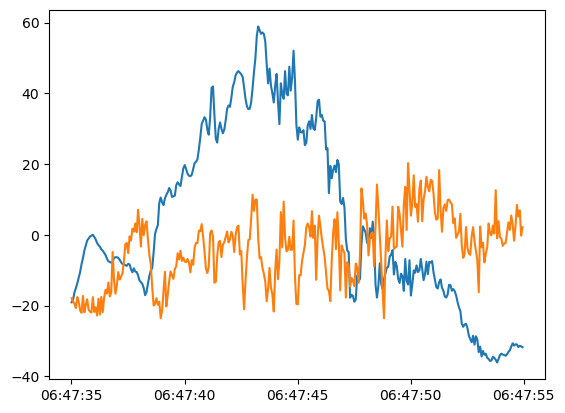

In [3]:
plt.plot(datetimes_dy,delta_B_E_align_dy)
plt.plot(datetimes_dy,E_north_dy)

In [4]:
## --- psd ---
delta_B_E_align_dy_psd = spectral.PSD(
    delta_B_E_align_dy,
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    window=window,
    scaling="density",
)  # same arguments setting as spectrogram
E_north_dy_psd = spectral.PSD(
    E_north_dy,
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    window=window,
    scaling="density",
)

frequencies_psd_dy, Pxx_delta_B_E_align_dy = delta_B_E_align_dy_psd.get_psd()
_, Pxx_E_north_dy = E_north_dy_psd.get_psd()

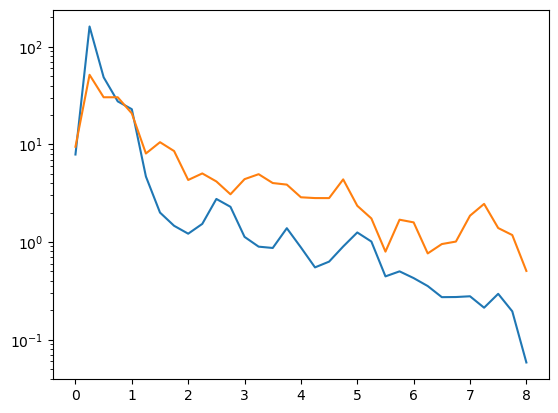

In [6]:
plt.plot(frequencies_psd_dy,Pxx_delta_B_E_align_dy)
plt.plot(frequencies_psd_dy,Pxx_E_north_dy)
plt.yscale('log')

In [ ]:

## --- cpsd ---

frequencies_spec_dy, ts_dy, Sxx_b_dy = spectrogram(
    delta_B_E_align_dy,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e_dy = spectrogram(
    E_north_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode="complex"
)

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), "s") for _ in ts_dy]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

## --- phase difference between b and E ---

num_bins = 50
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.03] = np.nan  # threshold
phase_bins_dy, phase_histogram2d_dy = histogram2d.get_phase_histogram2d(
    frequencies_spec_dy, cpsd_phase_dy, num_bins=num_bins
)

# --- static region ---
st_sta = np.datetime64("2016-03-11T06:47:05")
et_sta = np.datetime64("2016-03-11T06:47:25")
t_mask = (datetimes >= st_sta) & (datetimes <= et_sta)
datetimes_sta = datetimes[t_mask]
delta_B_E_align_sta = delta_B_E_align[t_mask]
E_north_sta = E_north[t_mask]

## --- pad ---
delta_B_E_align_sta_psd = spectral.PSD(
    delta_B_E_align_sta,
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    window=window,
    scaling="density",
)
E_north_sta_psd = spectral.PSD(
    E_north_sta,
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    window=window,
    scaling="density",
)

frequencies_psd_sta, Pxx_delta_B_E_align_sta_psd = delta_B_E_align_sta_psd.get_psd()
_, Pxx_E_north_sta_psd = E_north_sta_psd.get_psd()

## --- cpsd ---

frequencies_spec_sta, ts_sta, Sxx_b_sta = spectrogram(
    delta_B_E_align_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    mode="complex",
)
_, _, Sxx_e_sta = spectrogram(
    E_north_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    mode="complex",
)

ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), "s") for _ in ts_sta]

cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

## --- phase difference between b and E ---

num_bins = 50
cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < 0.03] = np.nan  # threshold
phase_bins_sta, phase_histogram2d_sta = histogram2d.get_phase_histogram2d(
    frequencies_spec_sta, cpsd_phase_sta, num_bins=num_bins
)

# --- ratio ---

eb_ratio_psd_dy = Pxx_E_north_dy / Pxx_delta_B_E_align_dy
eb_ratio_psd_sta = Pxx_E_north_sta_psd / Pxx_delta_B_E_align_sta_psd